## Music Generation using LSTM in Keras

### Installing Dependencies

In [12]:
pip install music21 numpy keras tensorflow mido

Note: you may need to restart the kernel to use updated packages.


### Parse MIDI Files & Extract Notes

In [13]:
from music21 import converter, instrument, note, chord
import glob
import pickle

notes = []

for file in glob.glob("midi_songs/*.mid"):
    midi = converter.parse(file)
    
    parts = instrument.partitionByInstrument(midi)
    if parts:  
        notes_to_parse = parts.parts[0].recurse()
    else:
        notes_to_parse = midi.flat.notes
    
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

with open("data/notes.pkl", "wb") as f:
    pickle.dump(notes, f)

print("✅ Notes extracted:", len(notes))


✅ Notes extracted: 79


###  Preparing Sequences for Model Input

In [14]:
import numpy as np
from keras.utils import to_categorical
import pickle

sequence_length = 25  # Reduced to avoid empty sequences

with open("data/notes.pkl", "rb") as f:
    notes = pickle.load(f)

# Reverse mapping
pitchnames = sorted(set(notes))
note_to_int = {note: number for number, note in enumerate(pitchnames)}
int_to_note = {number: note for note, number in note_to_int.items()}
n_vocab = len(pitchnames)

network_input = []
network_output = []

for i in range(0, len(notes) - sequence_length):
    seq_in = notes[i:i + sequence_length]
    seq_out = notes[i + sequence_length]
    network_input.append([note_to_int[note] for note in seq_in])
    network_output.append(note_to_int[seq_out])

n_patterns = len(network_input)
print(f"✅ Total sequences: {n_patterns}")

if n_patterns == 0:
    raise ValueError("❌ Not enough notes to create sequences. Consider reducing `sequence_length`.")

# Reshape input for LSTM
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
network_input = network_input / float(n_vocab)

# One-hot encode
network_output = to_categorical(network_output)

print("✅ Sequence preparation complete.")
print("Input shape:", network_input.shape)
print("Output shape:", network_output.shape)


✅ Total sequences: 54
✅ Sequence preparation complete.
Input shape: (54, 25, 1)
Output shape: (54, 12)


### Define & Train the LSTM Model

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

model = Sequential()
model.add(LSTM(256, input_shape=(network_input.shape[1], network_input.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
model.save("music_gen_model.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 25, 256)           264192    
                                                                 
 dropout_2 (Dropout)         (None, 25, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                1548      
                                                                 
 activation_1 (Activation)   (None, 12)               

In [16]:
history= model.fit(network_input, network_output, epochs=50, batch_size=32)

Epoch 1/50
2/2 [==============================] - 3s 51ms/step - loss: 2.3986
Epoch 2/50
2/2 [==============================] - 0s 52ms/step - loss: 1.9620
Epoch 3/50
2/2 [==============================] - 0s 54ms/step - loss: 2.1172
Epoch 4/50
2/2 [==============================] - 0s 59ms/step - loss: 1.8376
Epoch 5/50
2/2 [==============================] - 0s 70ms/step - loss: 1.8962
Epoch 6/50
2/2 [==============================] - 0s 53ms/step - loss: 1.8340
Epoch 7/50
2/2 [==============================] - 0s 54ms/step - loss: 1.7084
Epoch 8/50
2/2 [==============================] - 0s 54ms/step - loss: 1.7545
Epoch 9/50
2/2 [==============================] - 0s 65ms/step - loss: 1.7509
Epoch 10/50
2/2 [==============================] - 0s 55ms/step - loss: 1.7133
Epoch 11/50
2/2 [==============================] - 0s 55ms/step - loss: 1.7128
Epoch 12/50
2/2 [==============================] - 0s 52ms/step - loss: 1.7638
Epoch 13/50
2/2 [==============================] - 0s 53ms/st

In [17]:
model.save("music_model.h5")

###  Generate Notes from the Trained Model

In [18]:
import numpy as np

def generate_notes(model, network_input, int_to_note, n_vocab, generate_length=100):
    start = np.random.randint(0, len(network_input) - 1)
    pattern = network_input[start]
    pattern = pattern.reshape(1, len(pattern), 1)

    prediction_output = []

    for note_index in range(generate_length):
        prediction = model.predict(pattern, verbose=0)
        index = np.argmax(prediction)
        result = int_to_note.get(index, None)
        if result:
            prediction_output.append(result)

        # update input pattern
        pattern = np.append(pattern[:, 1:, :], [[ [index / float(n_vocab)] ]], axis=1)

    return prediction_output


###  Convert Notes to MIDI File

In [19]:
from music21 import instrument, note, chord, stream

def create_midi(prediction_output, filename="output.mid"):
    offset = 0
    output_notes = []

    for pattern in prediction_output:
        # chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            chord_notes = []
            for current_note in notes_in_chord:
                chord_notes.append(note.Note(int(current_note)))
            new_chord = chord.Chord(chord_notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            # single note
            new_note = note.Note(pattern)
            new_note.offset = offset
            output_notes.append(new_note)

        offset += 0.5  # duration between notes

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)


### Generate and Save Music

In [20]:
generated_notes = generate_notes(model, network_input, int_to_note, n_vocab, generate_length=100)
create_midi(generated_notes, filename="generated_music.mid")

### Visualize Top 20 Most Common Notes

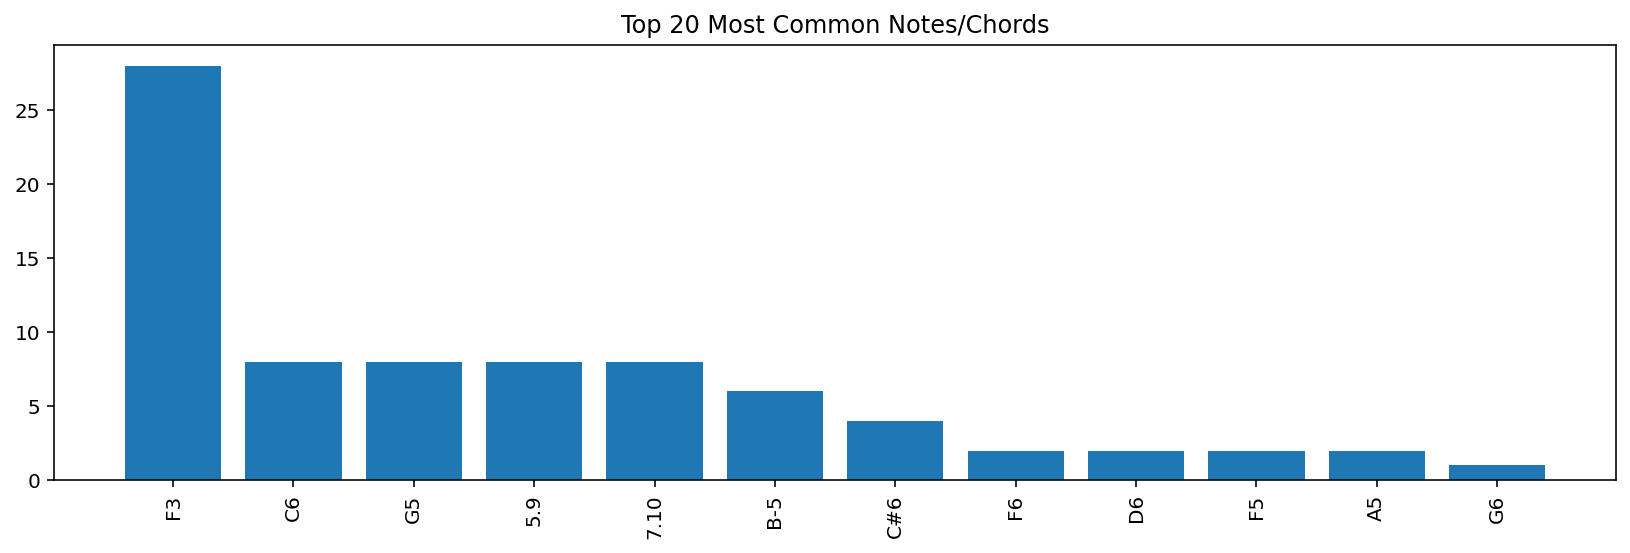

In [21]:
from collections import Counter
import matplotlib.pyplot as plt

note_counts = Counter(notes)
plt.figure(figsize=(14,4))
plt.bar(*zip(*note_counts.most_common(20)))
plt.title("Top 20 Most Common Notes/Chords")
plt.xticks(rotation=90)
plt.show()

### Training Loss Curve

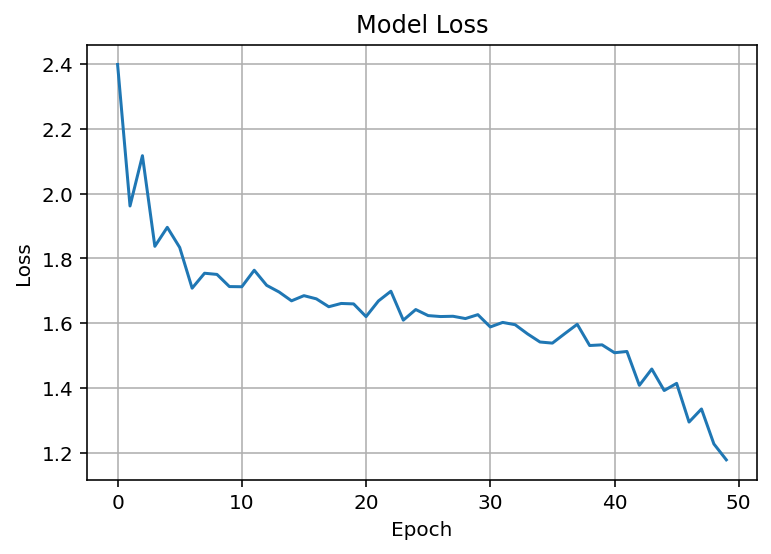

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.savefig("training_loss_curve.png")
plt.show()
